## Calc de gradient vector for a cavity. 

# Ahora voy a probar con un desplazamiento negativo y otro positivo, p/ calcular la derivada con estos 2 puntos y así obtener la derivada p/ el punto central (la struct average)

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [3]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [4]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [5]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [6]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [7]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
pdb_name = "tfo"
filename_pdb_file_original = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/cut_avg_", pdb_name, ".pdb")
pdb_filename = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/cut_avg_mto.pdb")
tfo_pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(tfo_pdb)
    push!(natom_res, length(tfo_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(tfo_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_tfo_1 = Array{Float64}(aa3-6);
vol_pocket_tfo_2 = Array{Float64}(aa3-6);
vol_pocket_tfo_3 = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);
factorr = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_tfo, evals_tfo = read_ptraj_modes("/home/german/labo/16/hemo/run/tfo/pca/modes_tfo", aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/tfo/"
# Archivos de config de ANA
conf_tfo_corto = "/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/tfo_corto.cfg"
conf_tfo_portal = "/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/tfo_portal.cfg"
conf_tfo_largo = "/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/tfo_largo.cfg"
conf_tfo_whole = "/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/tfo_whole.cfg"

"/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/tfo_whole.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por [-5 -4 -3 -2 -1 1 2 3 4 5]; y así obtener distintos desplazamientos. Creando así 10 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [8]:
# Constante q uso p/ ajustar el desplazamiento
constant = 5
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_tfo[i*3-2, j]
            modo_sum[i, 2] = modes_tfo[i*3-1, j]
            modo_sum[i, 3] = modes_tfo[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_tfo[j]
# Modifico las coordenadas
        tfo_atom_xyz = coordinatesmatrix(tfo_pdb)
        new_tfo_atom_xyz = tfo_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_tfo_pdb = change_coordinates(tfo_pdb, new_tfo_atom_xyz)
# Escribo el nuevo .pdb
        pdb_tfo = string(files_template, displacement, "/", "mod", j, "_", displacement, "_tfo.pdb")
        write(pdb_tfo, new_tfo_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 10 sets de 345 estructuras desplazadas. Y así junto 10 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 40 vectores y así obtengo 10 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [35]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_template, displacement, "/inndd_", pdb_name, "_", displacement)
    ndd_output_filename = string(files_template, displacement, "/outndd_", pdb_name, "_", displacement)
    pdb_filename = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_tfo.pdb")

# CORTO
    
    global vol_ndd = symbol("vol_ndd_corto_", displacement)  
    global gdte_ndd = symbol("gdte_ndd_corto_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_tfo_corto -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_tfo_corto`)))

# PORTAL
    
    global vol_ndd = symbol("vol_ndd_portal_", displacement)
    global gdte_ndd = symbol("gdte_ndd_portal_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_tfo_portal -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_tfo_portal`)))
    
# LARGO
    
    global vol_ndd = symbol("vol_ndd_largo_", displacement)
    global gdte_ndd = symbol("gdte_ndd_largo_", displacement)  
    # Calcv ulo el pocket        
    run(`ANA $pdb_filename -c $conf_tfo_largo -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_tfo_largo`)))
    
# WHOLE
    
    global vol_ndd = symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_tfo_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_tfo_whole`)))
end

248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84
248.221
586.498
1209.66
2805.84


### Ahora armo los vectores gradientes p/ c/ hueco y con c/ magnitud de desplazamiento. Termino teniendo 5 vectores gradiente p/ c/u de los 4 huecos. Luego compilo los gradientes de c/ hueco en 4 matrices.

In [36]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo. Repondero por los evals.
gdte_ndd_corto_dd1 = (vol_ndd_corto_d1 - vol_ndd_corto_d_1) .* evals_tfo
gdte_ndd_portal_dd1 = (vol_ndd_portal_d1 - vol_ndd_portal_d_1) .* evals_tfo 
gdte_ndd_largo_dd1 = (vol_ndd_largo_d1 - vol_ndd_largo_d_1) .* evals_tfo 
gdte_ndd_whole_dd1 = (vol_ndd_whole_d1 - vol_ndd_whole_d_1) .* evals_tfo;

gdte_ndd_corto_dd2 = (vol_ndd_corto_d2 - vol_ndd_corto_d_2) .* evals_tfo 
gdte_ndd_portal_dd2 = (vol_ndd_portal_d2 - vol_ndd_portal_d_2) .* evals_tfo 
gdte_ndd_largo_dd2 = (vol_ndd_largo_d2 - vol_ndd_largo_d_2) .* evals_tfo 
gdte_ndd_whole_dd2 = (vol_ndd_whole_d2 - vol_ndd_whole_d_2) .* evals_tfo;

gdte_ndd_corto_dd3 = (vol_ndd_corto_d3 - vol_ndd_corto_d_3) .* evals_tfo
gdte_ndd_portal_dd3 = (vol_ndd_portal_d3 - vol_ndd_portal_d_3) .* evals_tfo 
gdte_ndd_largo_dd3 = (vol_ndd_largo_d3 - vol_ndd_largo_d_3) .* evals_tfo 
gdte_ndd_whole_dd3 = (vol_ndd_whole_d3 - vol_ndd_whole_d_3) .* evals_tfo;

gdte_ndd_corto_dd4 = (vol_ndd_corto_d4 - vol_ndd_corto_d_4) .* evals_tfo
gdte_ndd_portal_dd4 = (vol_ndd_portal_d4 - vol_ndd_portal_d_4) .* evals_tfo 
gdte_ndd_largo_dd4 = (vol_ndd_largo_d4 - vol_ndd_largo_d_4) .* evals_tfo 
gdte_ndd_whole_dd4 = (vol_ndd_whole_d4 - vol_ndd_whole_d_4) .* evals_tfo;

gdte_ndd_corto_dd5 = (vol_ndd_corto_d5 - vol_ndd_corto_d_5) .* evals_tfo
gdte_ndd_portal_dd5 = (vol_ndd_portal_d5 - vol_ndd_portal_d_5) .* evals_tfo 
gdte_ndd_largo_dd5 = (vol_ndd_largo_d5 - vol_ndd_largo_d_5) .* evals_tfo 
gdte_ndd_whole_dd5 = (vol_ndd_whole_d5 - vol_ndd_whole_d_5) .* evals_tfo;

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_ndd_corto_dd1 = gdte_ndd_corto_dd1 / norm(gdte_ndd_corto_dd1)
gdte_ndd_portal_dd1 = gdte_ndd_portal_dd1 / norm(gdte_ndd_portal_dd1)
gdte_ndd_largo_dd1 = gdte_ndd_largo_dd1 / norm(gdte_ndd_largo_dd1)
gdte_ndd_whole_dd1 = gdte_ndd_whole_dd1 / norm(gdte_ndd_whole_dd1);

gdte_ndd_corto_dd2 = gdte_ndd_corto_dd2 / norm(gdte_ndd_corto_dd2)
gdte_ndd_portal_dd2 = gdte_ndd_portal_dd2 / norm(gdte_ndd_portal_dd2)
gdte_ndd_largo_dd2 = gdte_ndd_largo_dd2 / norm(gdte_ndd_largo_dd2)
gdte_ndd_whole_dd2 = gdte_ndd_whole_dd2 / norm(gdte_ndd_whole_dd2);

gdte_ndd_corto_dd3 = gdte_ndd_corto_dd3 / norm(gdte_ndd_corto_dd3)
gdte_ndd_portal_dd3 = gdte_ndd_portal_dd3 / norm(gdte_ndd_portal_dd3)
gdte_ndd_largo_dd3 = gdte_ndd_largo_dd3 / norm(gdte_ndd_largo_dd3)
gdte_ndd_whole_dd3 = gdte_ndd_whole_dd3 / norm(gdte_ndd_whole_dd3);

gdte_ndd_corto_dd4 = gdte_ndd_corto_dd4 / norm(gdte_ndd_corto_dd4)
gdte_ndd_portal_dd4 = gdte_ndd_portal_dd4 / norm(gdte_ndd_portal_dd4)
gdte_ndd_largo_dd4 = gdte_ndd_largo_dd4 / norm(gdte_ndd_largo_dd4)
gdte_ndd_whole_dd4 = gdte_ndd_whole_dd4 / norm(gdte_ndd_whole_dd4);

gdte_ndd_corto_dd5 = gdte_ndd_corto_dd5 / norm(gdte_ndd_corto_dd5)
gdte_ndd_portal_dd5 = gdte_ndd_portal_dd5 / norm(gdte_ndd_portal_dd5)
gdte_ndd_largo_dd5 = gdte_ndd_largo_dd5 / norm(gdte_ndd_largo_dd5)
gdte_ndd_whole_dd5 = gdte_ndd_whole_dd5 / norm(gdte_ndd_whole_dd5);

# Compilo los 5 gradientes de distintos desplazamientos en 1 matriz. Hago esto p/ los 4 huecos
gdte_ndd_corto = [gdte_ndd_corto_dd1 gdte_ndd_corto_dd2 gdte_ndd_corto_dd3 gdte_ndd_corto_dd4 gdte_ndd_corto_dd5]
gdte_ndd_portal = [gdte_ndd_portal_dd1 gdte_ndd_portal_dd2 gdte_ndd_portal_dd3 gdte_ndd_portal_dd4 gdte_ndd_portal_dd5]
gdte_ndd_largo = [gdte_ndd_largo_dd1 gdte_ndd_largo_dd2 gdte_ndd_largo_dd3 gdte_ndd_largo_dd4 gdte_ndd_largo_dd5]
gdte_ndd_whole = [gdte_ndd_whole_dd1 gdte_ndd_whole_dd2 gdte_ndd_whole_dd3 gdte_ndd_whole_dd4 gdte_ndd_whole_dd5];

### Comparo los vectores obtenidos con distintos desplazamientos

### Canal corto

In [37]:
transpose(gdte_ndd_corto) * gdte_ndd_corto

5x5 Array{Float64,2}:
 1.0       0.967227  0.976852  0.973569  0.976643
 0.967227  1.0       0.986967  0.987129  0.989485
 0.976852  0.986967  1.0       0.994223  0.993862
 0.973569  0.987129  0.994223  1.0       0.995961
 0.976643  0.989485  0.993862  0.995961  1.0     

### Canal portal

In [38]:
transpose(gdte_ndd_portal) * gdte_ndd_portal

5x5 Array{Float64,2}:
 1.0       0.970272  0.979419  0.973562  0.976884
 0.970272  1.0       0.990147  0.989895  0.990637
 0.979419  0.990147  1.0       0.99457   0.995175
 0.973562  0.989895  0.99457   1.0       0.996967
 0.976884  0.990637  0.995175  0.996967  1.0     

### Canal largo

In [39]:
transpose(gdte_ndd_largo) * gdte_ndd_largo

5x5 Array{Float64,2}:
 1.0       0.965082  0.974807  0.971437  0.97411 
 0.965082  1.0       0.986389  0.98754   0.988937
 0.974807  0.986389  1.0       0.992272  0.99347 
 0.971437  0.98754   0.992272  1.0       0.996785
 0.97411   0.988937  0.99347   0.996785  1.0     

### Canal whole

In [40]:
transpose(gdte_ndd_whole) * gdte_ndd_whole

5x5 Array{Float64,2}:
 1.0       0.966267  0.979391  0.974171  0.975604
 0.966267  1.0       0.988825  0.990222  0.990114
 0.979391  0.988825  1.0       0.994857  0.995595
 0.974171  0.990222  0.994857  1.0       0.996808
 0.975604  0.990114  0.995595  0.996808  1.0     

### Guardo todos los vectores gradiente 

In [41]:
for magnitude in [1 2 3 4 5]
    # Get filename ready
    displacement = string("dd", magnitude)
    out_filename_gdte_corto = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/", displacement,"_NDD_corto_tfo")
    out_filename_gdte_portal = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/", displacement,"_NDD_portal_tfo")
    out_filename_gdte_largo = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/", displacement,"_NDD_largo_tfo")
    out_filename_gdte_whole = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/", displacement,"_NDD_whole_tfo")
    # Get variable ready
    @eval (df_gdte_corto = DataFrame(delta = $(symbol("gdte_ndd_corto_", displacement))))
    @eval (df_gdte_portal = DataFrame(delta = $(symbol("gdte_ndd_portal_", displacement))))
    @eval (df_gdte_largo = DataFrame(delta = $(symbol("gdte_ndd_largo_", displacement))))
    @eval (df_gdte_whole = DataFrame(delta = $(symbol("gdte_ndd_whole_", displacement))))
    writetable(out_filename_gdte_corto, df_gdte_corto)
    writetable(out_filename_gdte_portal, df_gdte_portal)
    writetable(out_filename_gdte_largo, df_gdte_largo)
    writetable(out_filename_gdte_whole, df_gdte_whole)
end

## Me quedo con los gradientes obtenidos con un desplazamiento entre -2 y 2 y comparo estos con los obtenidos sin desplazar según frecuencia (desplazamiento uniforme)

### Leo los vectores obtenidos con desplazamientos uniformes

In [42]:
in_filename_gdte_corto_nonfreq = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/dd2_NDD_corto_tfo")
in_filename_gdte_portal_nonfreq = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/dd2_NDD_portal_tfo")
in_filename_gdte_largo_nonfreq = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/dd2_NDD_largo_tfo")
in_filename_gdte_whole_nonfreq = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/dd2_NDD_whole_tfo")

nonfreq_gdte_ndd_corto_dd2 = readtable(in_filename_gdte_corto_nonfreq)[:delta]
nonfreq_gdte_ndd_portal_dd2 = readtable(in_filename_gdte_portal_nonfreq)[:delta]
nonfreq_gdte_ndd_largo_dd2 = readtable(in_filename_gdte_largo_nonfreq)[:delta]
nonfreq_gdte_ndd_whole_dd2 = readtable(in_filename_gdte_whole_nonfreq)[:delta];

### Los comparo con los recién obtenidos

In [43]:
corto_comparison = (nonfreq_gdte_ndd_corto_dd2 - gdte_ndd_corto_dd2) ./ gdte_ndd_corto_dd2
portal_comparison = (nonfreq_gdte_ndd_portal_dd2 - gdte_ndd_portal_dd2) ./ gdte_ndd_portal_dd2
largo_comparison = (nonfreq_gdte_ndd_largo_dd2 - gdte_ndd_largo_dd2) ./ gdte_ndd_largo_dd2
whole_comparison = (nonfreq_gdte_ndd_whole_dd2 - gdte_ndd_whole_dd2) ./ gdte_ndd_whole_dd2;

### Canal corto

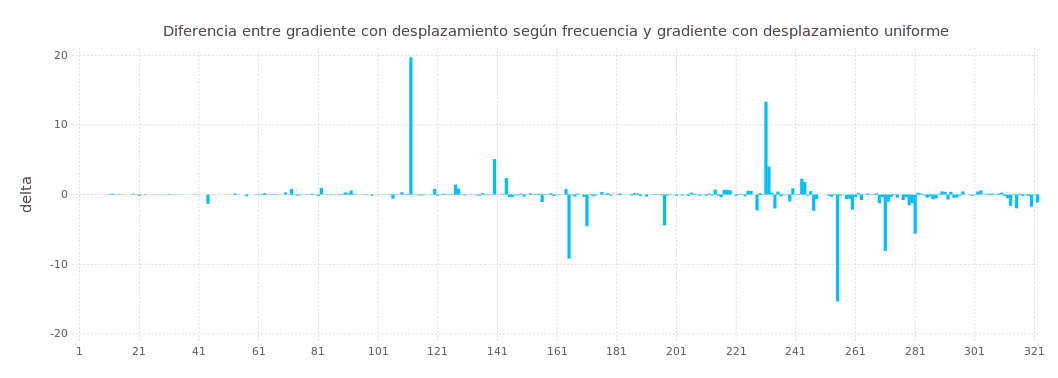

In [44]:
df_corto_comparison = DataFrame(delta = corto_comparison)
pdf_corto_comparison = plot(df_corto_comparison,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("Diferencia entre gradiente con desplazamiento según frecuencia y gradiente con desplazamiento uniforme"),
Coord.Cartesian(xmin=1, xmax=320),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Canal portal

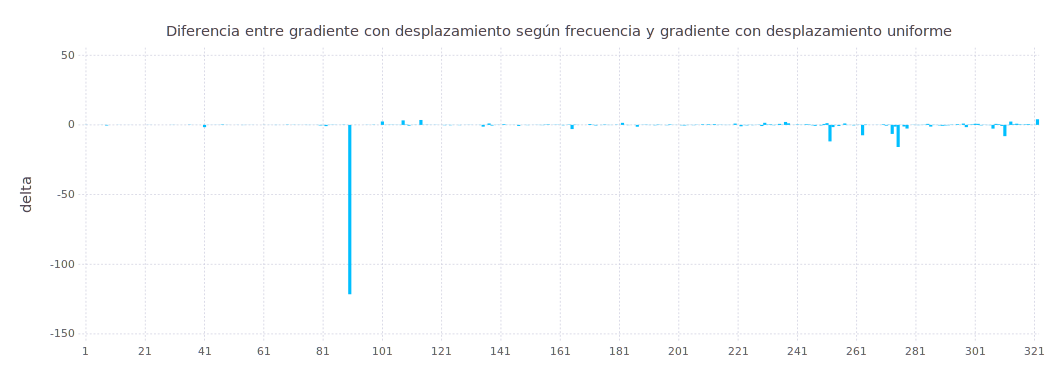

In [45]:
df_portal_comparison = DataFrame(delta = portal_comparison)
pdf_portal_comparison = plot(df_portal_comparison,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("Diferencia entre gradiente con desplazamiento según frecuencia y gradiente con desplazamiento uniforme"),
Coord.Cartesian(xmin=1, xmax=320),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Canal largo

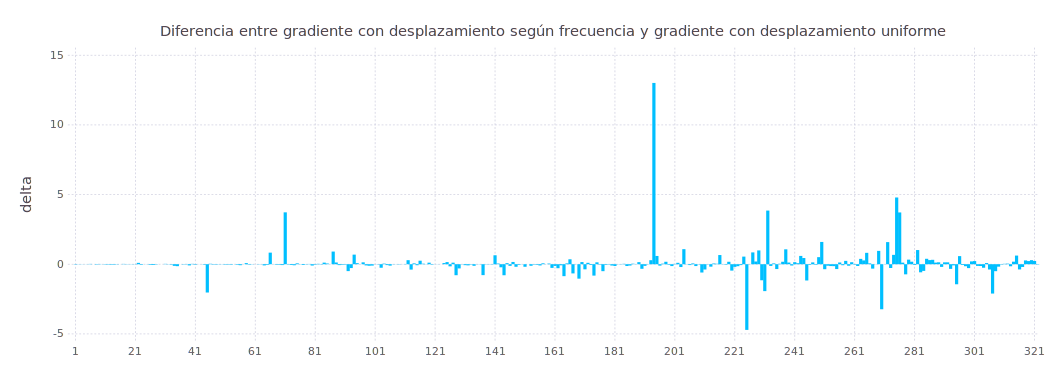

In [46]:
df_largo_comparison = DataFrame(delta = largo_comparison)
pdf_largo_comparison = plot(df_largo_comparison,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("Diferencia entre gradiente con desplazamiento según frecuencia y gradiente con desplazamiento uniforme"),
Coord.Cartesian(xmin=1, xmax=320),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Canal whole

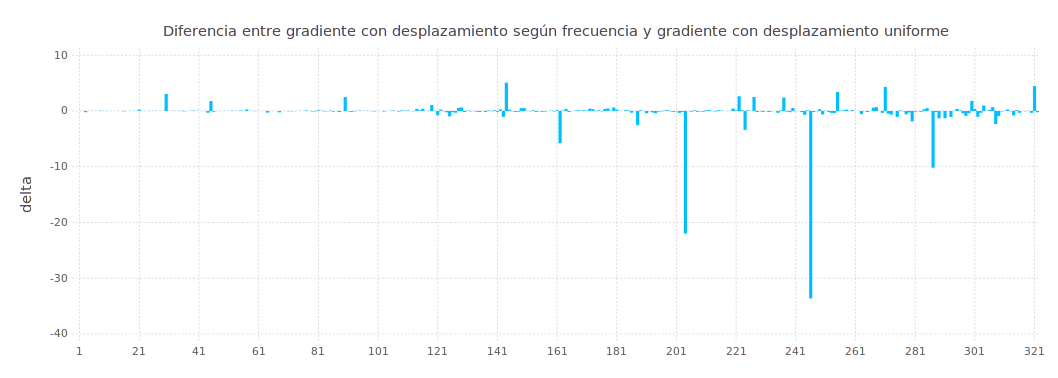

In [47]:
df_whole_comparison = DataFrame(delta = whole_comparison)
pdf_whole_comparison = plot(df_whole_comparison,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("Diferencia entre gradiente con desplazamiento según frecuencia y gradiente con desplazamiento uniforme"),
Coord.Cartesian(xmin=1, xmax=320),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))